## Importing libs

In [16]:
import numpy as np
import pandas as pd
import os

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Working with data

In [19]:
PATH_TO_DATA = './data/'

In [20]:
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'))
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X = train.drop(columns=['label']).values.astype('uint8')
y = train['label'].values.astype('uint8')
X_test = test.drop(columns=['id']).values.astype('uint8')

In [23]:
X = X.reshape((X.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [24]:
X = X / 255.
X_test = X_test / 255.

In [25]:
print(y)

[0 1 2 ... 7 8 9]


In [26]:
y = to_categorical(y, num_classes=10)
print(y.shape)

(60000, 10)


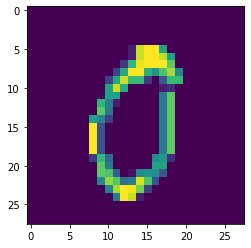

In [27]:
plt.imshow(X[0])
plt.show()

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=123)
print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X validation shape:", X_val.shape)
print("y validation shape:", y_val.shape)

X train shape: (45000, 28, 28, 1)
y train shape: (45000, 10)
X validation shape: (15000, 28, 28, 1)
y validation shape: (15000, 10)


## Model

In [72]:
class ConvModel(tf.keras.Model):

    def __init__(self):
        super(ConvModel, self).__init__()
        
        self.conv1 = tfl.Conv2D(
                 64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1))
        self.bn_conv1 = tfl.BatchNormalization()
        self.maxpool1 = tfl.MaxPooling2D(pool_size=(2, 2))
        self.dropout1 = tfl.Dropout(0.25)
        
        self.conv2 = tfl.Conv2D(
                 128, kernel_size=(3, 3),
                 activation='relu')
        self.bn_conv2 = tfl.BatchNormalization()
        self.maxpool2 = tfl.MaxPooling2D(pool_size=(2, 2))
        self.dropout2 = tfl.Dropout(0.25)
        
        self.flatten = tfl.Flatten()
        self.dense1 = tfl.Dense(256, activation='relu')
        self.bn_dense1 = tfl.BatchNormalization()
        self.dense2 = tfl.Dense(128, activation='relu')
        self.bn_dense2 = tfl.BatchNormalization()
        
        self.prediction_layer = tfl.Dense(10, activation='softmax')
        

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn_conv1(x)
        x = self.maxpool1(x)
        if training:
            x = self.dropout1(x)
            
        x = self.conv2(x)
        x = self.bn_conv2(x)
        x = self.maxpool2(x)
        if training:
            x = self.dropout2(x)
            
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.bn_dense1(x)
        x = self.dense2(x)
        x = self.bn_dense2(x)
        
        return self.prediction_layer(x)
    
perceptron = ConvModel()

In [73]:
def create_train_predict_model(model, 
                       optimizer=Adam(), 
                       loss=CategoricalCrossentropy(), 
                       metrics=[CategoricalAccuracy()],
                       training=True,
                       epochs=300):
    model = model()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    test_pred = model.predict(X_test)
    return test_pred, history

In [75]:
prediction, history = create_train_predict_model(model=ConvModel, epochs=30, training=True)

Epoch 1/30
1407/1407 [==============================] - 69s 49ms/step - loss: 0.0818 - categorical_accuracy: 0.9686 - val_loss: 0.0371 - val_categorical_accuracy: 0.9891
Epoch 2/30
1407/1407 [==============================] - 89s 63ms/step - loss: 0.0389 - categorical_accuracy: 0.9881 - val_loss: 0.0283 - val_categorical_accuracy: 0.9917
Epoch 3/30
1407/1407 [==============================] - 90s 64ms/step - loss: 0.0300 - categorical_accuracy: 0.9908 - val_loss: 0.0245 - val_categorical_accuracy: 0.9937
Epoch 4/30
1407/1407 [==============================] - 106s 75ms/step - loss: 0.0247 - categorical_accuracy: 0.9922 - val_loss: 0.0265 - val_categorical_accuracy: 0.9934
Epoch 5/30
1407/1407 [==============================] - 103s 73ms/step - loss: 0.0208 - categorical_accuracy: 0.9937 - val_loss: 0.0270 - val_categorical_accuracy: 0.9927
Epoch 6/30
1407/1407 [==============================] - 103s 73ms/step - loss: 0.0177 - categorical_accuracy: 0.9944 - val_loss: 0.0234 - val_catego

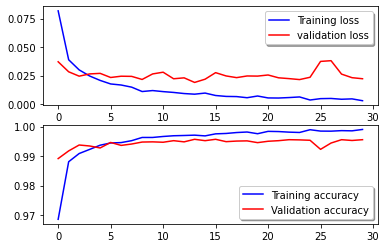

In [78]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [96]:
submission = pd.read_csv(os.path.join(PATH_TO_DATA, 'sample_submission.csv'))
# prediction = np.argmax(prediction, axis=1)
submission['label'] = prediction
submission.to_csv(os.path.join(PATH_TO_DATA, "ConvModel.csv"), index=False)

In [92]:
print(prediction)

[3 0 2 ... 1 6 3]
